In [57]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pickle

import scipy
import numpy as np

from astropy.io import fits
from astropy.table import Table, Column, vstack, hstack
from astropy.stats import sigma_clipped_stats, sigma_clip

import matplotlib as mpl
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- For selecting massive galaxies in the DECaLS survey, we match the DECaLS `Tractor` and photo-z catalogs to the COSMOS2020 `Farmer` catalog, which is also based on `Tractor` modeling of more than 30-bands of UV-Optical-NIR images. 


# DECaLS COSMOS Catalogs

- The RA, Dec boundaries are: RA= [149.22484, 150.81303], Dec=[1.541319, 2.87744]
    - Based on the COSMOS20202 HSC flag region

- COSMOS 2 deg$^2$ field is split into two `sweeps`. The DR9 `Tractor` catalogs are here:
	- [`sweep-140p000-150p005.fits`](https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/sweep/9.0/sweep-140p000-150p005.fits)
	- [`sweep-150p000-160p005.fits`](https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/sweep/9.0/sweep-150p000-160p005.fits)

- The DR9 photo-z catalogs are here:
	- [`sweep-140p000-150p005-pz.fits`](https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/sweep/9.0-photo-z/sweep-140p000-150p005-pz.fits)
	- [`sweep-150p000-160p005-pz.fits`](https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/sweep/9.0-photo-z/sweep-150p000-160p005-pz.fits)

- Combined these catalogs into a single one and make the COSMOS2020 HSC flag cut:
	- **184140** objects left in the sample.
		- Among them **176523** pass the photo-z selection cut (`NOBS_[G/R/Z] > 1` and `FLUX_IVAR_[G/R/Z] >0`) and also have useful photo-z.
			- And if we restrict to `NOBS_[G/R/Z] >= 3`, there are **136152** objects left.
	- Saved as `decals_tractor_photoz_cosmos2020_hsc.fits`

- Photo-z 
	- Using the 1-Sigma range of the photo-z PDF (`Z_PHOT_L68` and `Z_PHOT_U68`):
		- There are ~20000 galaxies left at $0.05 < z < 0.55$
		- There are ~10000 galaxies left at $0.05 < z < 0.45$

In [190]:
decals_dir = '/Users/song/Dropbox/work/data/legacyhalos/decals_cosmos/'

tr_1 = Table.read(os.path.join(decals_dir, 'sweep-140p000-150p005.fits'))
tr_2 = Table.read(os.path.join(decals_dir, 'sweep-150p000-160p005.fits'))

pz_1 = Table.read(os.path.join(decals_dir, 'sweep-140p000-150p005-pz.fits'))
pz_2 = Table.read(os.path.join(decals_dir, 'sweep-150p000-160p005-pz.fits'))

print(len(tr_1), len(tr_2))

4142555 4070265


In [54]:
print(tr_1.colnames)

['RELEASE', 'BRICKID', 'BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'RA_IVAR', 'DEC_IVAR', 'DCHISQ', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FLUX_IVAR_W3', 'FLUX_IVAR_W4', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'MW_TRANSMISSION_W3', 'MW_TRANSMISSION_W4', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'NOBS_W1', 'NOBS_W2', 'NOBS_W3', 'NOBS_W4', 'RCHISQ_G', 'RCHISQ_R', 'RCHISQ_Z', 'RCHISQ_W1', 'RCHISQ_W2', 'RCHISQ_W3', 'RCHISQ_W4', 'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACFLUX_W1', 'FRACFLUX_W2', 'FRACFLUX_W3', 'FRACFLUX_W4', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'ANYMASK_G', 'ANYMASK_R', 'ANYMASK_Z', 'ALLMASK_G', 'ALLMASK_R', 'ALLMASK_Z', 'WISEMASK_W1', 'WISEMASK_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH

In [55]:
print(pz_1.colnames)

['RELEASE', 'BRICKID', 'OBJID', 'Z_PHOT_MEAN', 'Z_PHOT_MEDIAN', 'Z_PHOT_STD', 'Z_PHOT_L68', 'Z_PHOT_U68', 'Z_PHOT_L95', 'Z_PHOT_U95', 'Z_SPEC', 'SURVEY', 'TRAINING']


In [56]:
ra_min, ra_max = 149.22484, 150.81303
dec_min, dec_max = 1.541319, 2.87744 

pz_1.rename_column('RELEASE', 'RELEASE_PZ')
pz_1.rename_column('BRICKID', 'BRICKID_PZ')
pz_1.rename_column('OBJID', 'OBJID_PZ')

pz_2.rename_column('RELEASE', 'RELEASE_PZ')
pz_2.rename_column('BRICKID', 'BRICKID_PZ')
pz_2.rename_column('OBJID', 'OBJID_PZ')

decals_comb = vstack([hstack([tr_1, pz_1]), hstack([tr_2, pz_2])])

assert np.all(a['RELEASE'] == a['RELEASE_PZ'])
assert np.all(a['BRICKID'] == a['BRICKID_PZ'])
assert np.all(a['OBJID'] == a['OBJID_PZ'])

cos_mask = (
    (decals_comb['RA'] >= ra_min) & (decals_comb['RA'] <= ra_max) &
    (decals_comb['DEC'] >= dec_min) & (decals_comb['DEC'] <= dec_max)
)

decals_cos = decals_comb[cos_mask]

print(len(decals_cos))

decals_cos.remove_columns(['RELEASE_PZ', 'BRICKID_PZ', 'OBJID_PZ'])

decals_cos.write(os.path.join(decals_dir, 'decals_tractor_photoz_cosmos2020_hsc.fits'))

In [74]:
mask_valid = (
    (decals_cos['NOBS_G'] > 1) & (decals_cos['NOBS_R'] > 1) & (decals_cos['NOBS_Z'] > 1) & 
    (decals_cos['FLUX_IVAR_G'] > 0) & (decals_cos['FLUX_IVAR_R'] > 0) & (decals_cos['FLUX_IVAR_Z'] > 0) &
    (decals_cos['FLUX_G'] > 0) & (decals_cos['FLUX_R'] > 0) & (decals_cos['FLUX_Z'] > 0) &
    (decals_cos['Z_PHOT_MEAN'] >= 0.0) & (decals_cos['Z_PHOT_MEAN'] <= 7.0)
)

print(mask_valid.sum())

mask_good = (
    (decals_cos['NOBS_G'] >= 3) & (decals_cos['NOBS_R'] >= 3) & (decals_cos['NOBS_Z'] >= 3) & 
    (decals_cos['FLUX_IVAR_G'] > 0) & (decals_cos['FLUX_IVAR_R'] > 0) & (decals_cos['FLUX_IVAR_Z'] > 0) &
    (decals_cos['FLUX_G'] > 0) & (decals_cos['FLUX_R'] > 0) & (decals_cos['FLUX_Z'] > 0) &
    (decals_cos['Z_PHOT_MEAN'] >= 0.0) & (decals_cos['Z_PHOT_MEAN'] <= 7.0)
)

print(mask_good.sum())

decals_valid = decals_cos[mask_valid]
decals_good = decals_cos[mask_good]

176523
136152


/tmp/ipykernel_89889/2500048066.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


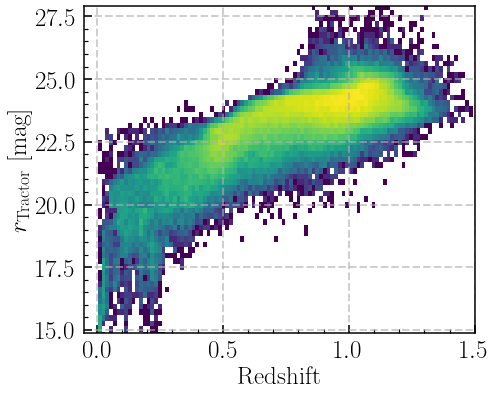

In [90]:
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    decals_good['Z_PHOT_MEAN'], -2.5 * np.log10(decals_good['FLUX_R']) + 22.5, 
    bins=(100, 100), cmin=1, cmap='viridis', norm=mpl.colors.LogNorm())

ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(-0.05, 1.5)
_ = ax.set_ylim(14.9, 27.9)

_ = ax.set_xlabel(r'$\rm Redshift$', fontsize=25)
_ = ax.set_ylabel(r'$r_{\rm Tractor}\ [\rm mag]$', fontsize=25)

In [409]:
print("# Safer choice:")
print(((decals_valid['Z_PHOT_L68'] >= 0.05) & (decals_valid['Z_PHOT_U68'] <= 0.45)).sum())
print(((decals_valid['Z_PHOT_L68'] >= 0.05) & (decals_valid['Z_PHOT_U68'] <= 0.55)).sum())

print("\n# More complete choice:")
print(((decals_valid['Z_PHOT_U68'] >= 0.05) & (decals_valid['Z_PHOT_L68'] <= 0.45)).sum())
print(((decals_valid['Z_PHOT_U68'] >= 0.05) & (decals_valid['Z_PHOT_L68'] <= 0.55)).sum())

print("\n# Fiducial choice:")
print(((decals_valid['Z_PHOT_MEAN'] >= 0.05) & (decals_valid['Z_PHOT_MEAN'] <= 0.45)).sum())
print(((decals_valid['Z_PHOT_MEAN'] >= 0.05) & (decals_valid['Z_PHOT_MEAN'] <= 0.55)).sum())

# Safer choice:
10823
20116

# More complete choice:
51584
80085

# Fiducial choice:
23163
38559


# COSMOS 2020 Farmer Catalog

- [The COSMOS2020 catalog](https://astroweaver.github.io/project/cosmos2020-galaxy-catalog/)
    - [COSMOS2020: A panchromatic view of the Universe to z∼10 from two complementary catalogs](https://arxiv.org/abs/2110.13923)

In [2]:
cosmos_dir = '/Users/song/work/cosmos2020/COSMOS2020_R1/'

glob.glob(cosmos_dir + '*.fits')

['/Users/song/work/cosmos2020/COSMOS2020_R1/COSMOS2020_FARMER_R1_v2.0.fits',
 '/Users/song/work/cosmos2020/COSMOS2020_R1/COSMOS2020_CLASSIC_R1_v2.0.fits']

- Using the `Farmer` catalog: `COSMOS2020_FARMER_R1_v2.0.fits`
	- Only keep the useful columns; Only keep the objects with `FLAT_HSC == 0`. There are **958926** objects. 
	- This one has been filtered through the HSC bright star mask. 
	- The RA, Dec boundaries are: RA= [149.22484, 150.81303], Dec=[1.541319, 2.87744]
	- **Note**: Not all objects here have valid `Tractor` models for the HSC bands.
	- Saved as `cosmos2020_farmer_hsc_short.fits`

In [611]:
c20_farmer = Table.read(os.path.join(cosmos_dir, 'COSMOS2020_FARMER_R1_v2.0.fits'))

print(len(c20_farmer))

964506


In [635]:
cols_use = ['ID', 'ID_CLASSIC', 'ALPHA_J2000', 'DELTA_J2000', 'N_GROUP', 'FLAG_HSC', 'FLAG_UVISTA', 'FLAG_COMBINED', 'EBV_MW', 
            'HSC_g_MAG', 'HSC_g_MAGERR', 'HSC_g_CHISQ', 'HSC_g_VALID', 
            'HSC_r_MAG', 'HSC_r_MAGERR', 'HSC_r_CHISQ', 'HSC_r_VALID', 
            'HSC_i_MAG', 'HSC_i_MAGERR', 'HSC_i_CHISQ', 'HSC_i_VALID', 
            'HSC_z_MAG', 'HSC_z_MAGERR', 'HSC_z_CHISQ', 'HSC_z_VALID', 
            'HSC_y_MAG', 'HSC_y_MAGERR', 'HSC_y_CHISQ', 'HSC_y_VALID', 
            'UVISTA_Y_MAG', 'UVISTA_Y_MAGERR', 'UVISTA_Y_CHISQ', 'UVISTA_Y_VALID',
            'UVISTA_J_MAG', 'UVISTA_J_MAGERR', 'UVISTA_J_CHISQ', 'UVISTA_J_VALID',
            'UVISTA_H_MAG', 'UVISTA_H_MAGERR', 'UVISTA_H_CHISQ', 'UVISTA_H_VALID',
            'UVISTA_Ks_MAG', 'UVISTA_Ks_MAGERR', 'UVISTA_Ks_CHISQ', 'UVISTA_Ks_VALID',
            'F814W_MAG', 'F814W_MAGERR', 'SOLUTION_MODEL',
            'lp_zBEST', 'lp_type', 'lp_zPDF', 'lp_zPDF_l68', 'lp_zPDF_u68', 
            'lp_MNUV', 'lp_MU', 'lp_MR', 'lp_MZ', 'lp_MJ', 
            'lp_mass_med', 'lp_mass_med_min68', 'lp_mass_med_max68', 'lp_mass_best', 
            'lp_SFR_med', 'lp_SFR_med_min68', 'lp_SFR_med_max68', 'lp_SFR_best', 
            'lp_sSFR_med', 'lp_sSFR_med_min68', 'lp_sSFR_med_max68', 'lp_sSFR_best',
            'ez_z_phot', 'ez_z_phot_chi2', 'ez_z025', 'ez_z160', 'ez_z500', 'ez_z840', 'ez_z975',
            'ez_restU', 'ez_restU_err', 'ez_restB', 'ez_restB_err', 'ez_restV', 'ez_restV_err', 'ez_restJ', 'ez_restJ_err',
            'ez_ssfr_p025', 'ez_ssfr_p160', 'ez_ssfr_p500', 'ez_ssfr_p840', 'ez_ssfr_p975',
            'ez_mass', 'ez_sfr', 'ez_mass_p025', 'ez_mass_p160', 'ez_mass_p500', 'ez_mass_p840', 'ez_mass_p975', 
            'ez_star_min_chi2'
           ] 

c20_short = c20_farmer[cols_use]

c20_short.rename_column('ALPHA_J2000', 'ra')
c20_short.rename_column('DELTA_J2000', 'dec')

In [636]:
# The HSC masked region
c20_hsc = c20_short[c20_short['FLAG_HSC'] == 0]

print(len(c20_hsc))

c20_hsc.write(os.path.join(cosmos_dir, 'cosmos2020_farmer_hsc_short.fits'), overwrite=True)

958926


In [637]:
## RA, Dec boundaries
print(c20_hsc['ra'].min(), c20_hsc['ra'].max())
print(c20_hsc['dec'].min(), c20_hsc['dec'].max())

149.22483699123012 150.8130254878658
1.5413190011997577 2.8774402606046996


In [642]:
np.unique(c20_hsc['SOLUTION_MODEL'].data)

masked_array(data=[b'DevGalaxy', b'ExpGalaxy', b'FixedCompositeGalaxy',
                   --, b'PointSource', b'SimpleGalaxy'],
             mask=[False, False, False,  True, False, False],
       fill_value=b'N/A',
            dtype='|S20')

In [650]:
c20_hsc_extend_flag = (c20_hsc['SOLUTION_MODEL'].data != b'PointSource')

## Select massive galaxies using LePhare results

- **Always use `lp_zPDF`; not `lp_zBest`**

- Use the `Tractor` model selection criteria to remove point sources.
    - `SOLUTION_MODEL != PointSource`

- **Note**
    - Cannot use the `lp_type == 0` (galaxy) selection; many galaxies are classified as _NOT_ galaxies by `LePhare` 
    - `LePhare` uses pre-computed `BC03` stellar population model with simple SFH.
    - It also uses $H_{0}=0.7$, $\Omega_{m}=0.3$, $\Omega_{\Lambda}=0.7$ cosmology.

- Use the `LePhare` photo-z as the reference for photo-z, stellar mass, and sSFR estimates. 
	- There are **197022** objects with valid HSC five-band photometry and `LePhare` info.

In [708]:
c20_lp_flag = (
    np.isfinite(c20_hsc['lp_zBEST']) & np.isfinite(c20_hsc['lp_mass_med']) & 
    np.isfinite(c20_hsc['lp_SFR_med']) & np.isfinite(c20_hsc['lp_sSFR_med']) &
    np.isfinite(c20_hsc['HSC_g_MAG']) & np.isfinite(c20_hsc['HSC_g_MAGERR']) &
    np.isfinite(c20_hsc['HSC_r_MAG']) & np.isfinite(c20_hsc['HSC_r_MAGERR']) &
    np.isfinite(c20_hsc['HSC_i_MAG']) & np.isfinite(c20_hsc['HSC_i_MAGERR']) &
    np.isfinite(c20_hsc['HSC_z_MAG']) & np.isfinite(c20_hsc['HSC_z_MAGERR']) &
    np.isfinite(c20_hsc['HSC_y_MAG']) & np.isfinite(c20_hsc['HSC_y_MAGERR']) &
    c20_hsc_extend_flag.data
)

c20_valid_lp = c20_hsc[c20_lp_flag]

print(len(c20_valid_lp))

197022


### Safer Choice

- Using the 1-Sigma range of the photo-z PDF (`lp_zPDF_l68` & `lp_zPDF_u68`) and the 1-Sigma range of the stellar mass PDF (`lp_mass_med_min68` & `lp_mass_med_max68`) as boundaries:
	- Given that we are using redshift and stellar mass PDFs, it is very likely the number density will be over-estimated. 
	- Meanwhile, for massive galaxies, COSMOS is not an over-density region at low-redshift, so it may under-represent the number of very massive galaxies.
	- Higher redshift cut:
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{10.5} M_{\star}$:  1373
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{10.8} M_{\star}$:  589
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{11.0} M_{\star}$:  271
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{11.5} M_{\star}$:  25
	- Lower redshift cut:
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{10.5} M_{\star}$:  873
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{10.8} M_{\star}$:  **376**; Use this as the fiducial low-z massive galaxy cut.
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.0} M_{\star}$:  168
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.2} M_{\star}$:  59
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.5} M_{\star}$:  16
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.6} M_{\star}$:  9

In [709]:
# s means safer
c20_lp_mass_s = c20_valid_lp[
    (c20_valid_lp['lp_zPDF_l68'].data >= 0.05) & (c20_valid_lp['lp_zPDF_l68'].data <= 0.45) &
    (c20_valid_lp['lp_mass_med_min68'].data >= 10.8) & (c20_valid_lp['lp_mass_med_max68'].data <= 12.7)
]

print(len(c20_lp_mass_s))

376


In [649]:
massive_pts = c20_hsc[
    (c20_hsc['lp_zPDF_l68'] >= 0.05) & (c20_hsc['lp_zPDF_l68'] <= 0.45) &
    (c20_hsc['lp_mass_med_min68'] >= 10.8) & (c20_hsc['lp_mass_med_max68'] <= 12.7) &
    ~c20_hsc_extend_flag
]

print(len(massive_pts))

_ = [print("{:7d}  {:8.4f}  {:8.4f}".format(obj['ID'], obj['ra'], obj['dec'])) for obj in massive_pts]

17
  37943  149.2718    1.5443
 104399  149.2554    1.8837
 118473  150.6666    2.5649
 148365  149.3352    1.9944
 149487  150.0853    2.6348
 467846  149.9670    2.8284
 512021  149.2303    1.9225
 521094  149.3471    2.2375
 530495  149.3100    2.6739
 549425  149.3063    2.2703
 605324  149.3213    2.5337
 693975  149.3039    1.6943
 718315  149.2835    2.7810
 760681  149.7115    2.8651
 949998  150.3539    2.8626
 950716  150.3506    2.8663
 964093  150.3868    2.8607


### Complete Choice:

- Using the 1-Sigma range of the photo-z PDF (`lp_zPDF_l68` & `lp_zPDF_u68`) and the 1-Sigma range of the stellar mass PDF (`lp_mass_med_min68` & `lp_mass_med_max68`) as boundaries. 
	- But use the `_u68` limit as the lower limit and the `_l68` limit as the upper boundary:
	- Higher redshift cut:
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{10.5} M_{\star}$:  1483
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{10.8} M_{\star}$:  660
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{11.0} M_{\star}$:  311
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{11.5} M_{\star}$:  29
	- Lower redshift cut:
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{10.5} M_{\star}$:  904
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{10.8} M_{\star}$:  **410**; Use this as the fiducial low-z massive galaxy cut.
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.0} M_{\star}$:  195
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.2} M_{\star}$:  78
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.5} M_{\star}$:  18
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.6} M_{\star}$:  9
        
- Sample size varies around 8% due to the `LePhare` photo-z and stellar mass PDFs.
    - We can handle this amount of increased sample, so should use the complete version.

In [672]:
# c means more complete
c20_lp_mass_c = c20_valid_lp[
    (c20_valid_lp['lp_zPDF_u68'] >= 0.05) & (c20_valid_lp['lp_zPDF_u68'] <= 0.45) &
    (c20_valid_lp['lp_mass_med_max68'] >= 10.8) & (c20_valid_lp['lp_mass_med_min68'] <= 12.7)
]

print(len(c20_lp_mass_c))

print((len(c20_lp_mass_c) - len(c20_lp_mass_s)) / len(c20_lp_mass_c))

410
0.08292682926829269


### `LePhare` - Complete - Magnitued and Color Ranges 

- Using `HSC` photometry:

#### HSC magnitude: 

- Use 99.9% instead of the real maximum values to avoid any outliers.
- $g_{\rm Max} = 23.0$ mag : 3.9% of the sample after a magnitude cut (10457 objects).
- $r_{\rm Max} = 21.3$ mag : 9.0% of the sample after a magnitude cut (4520 objects).
- $i_{\rm Max} = 20.6$ mag : 12.0% of the sample after a magnitude cut (3404 objects).
- $z_{\rm Max} = 20.2$ mag : 13.7% of the sample after a magnitude cut (2982 objects).
	- **$z$-band photometry is the most constraining one if ignoring the data quality issue.**

In [674]:
lp_g_lim = np.percentile(c20_lp_mass_c['HSC_g_MAG'], 99.9)
lp_r_lim = np.percentile(c20_lp_mass_c['HSC_r_MAG'], 99.9)
lp_i_lim = np.percentile(c20_lp_mass_c['HSC_i_MAG'], 99.9)
lp_z_lim = np.percentile(c20_lp_mass_c['HSC_z_MAG'], 99.9)

lp_g_flag = (c20_valid_lp['HSC_g_MAG'] <= lp_g_lim)
lp_r_flag = (c20_valid_lp['HSC_r_MAG'] <= lp_r_lim)
lp_i_flag = (c20_valid_lp['HSC_i_MAG'] <= lp_i_lim)
lp_z_flag = (c20_valid_lp['HSC_z_MAG'] <= lp_z_lim)

print(lp_g_lim, len(c20_lp_mass_c) / lp_g_flag.sum(), lp_g_flag.sum())
print(lp_r_lim, len(c20_lp_mass_c) / lp_r_flag.sum(), lp_r_flag.sum())
print(lp_i_lim, len(c20_lp_mass_c) / lp_i_flag.sum(), lp_i_flag.sum())
print(lp_z_lim, len(c20_lp_mass_c) / lp_z_flag.sum(), lp_z_flag.sum())

/Users/song/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


22.967616962687327 0.039208185904179016 10457
21.338953141692883 0.09070796460176991 4520
20.582133402438394 0.12044653349001175 3404
20.162989929474165 0.1374916163648558 2982


/tmp/ipykernel_89889/2815992635.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


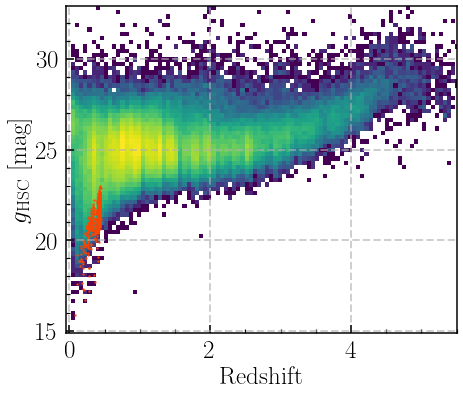

In [673]:
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    c20_valid_lp['lp_zPDF'], c20_valid_lp['HSC_g_MAG'], 
    bins=(150, 100), cmin=1, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    c20_lp_mass_c['lp_zPDF'], c20_lp_mass_c['HSC_g_MAG'], s=2, c='orangered', alpha=0.8
)

ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(-0.05, 5.5)
_ = ax.set_ylim(14.9, 32.9)

_ = ax.set_xlabel(r'$\rm Redshift$', fontsize=25)
_ = ax.set_ylabel(r'$g_{\rm HSC}\ [\rm mag]$', fontsize=25)

#### HSC colors: only consider $g-r$, $r-z$, and $g-z$:

- There are tiny fraction of outliers of these objects. Need to use sigma-clipping. 
	- Over the $g-r$ v.s. $r-z$ plane, the massive sample forms a triangular "wedge"-like region.
	- $(g-r)$ ranges from 0.88 - 1.96 mag
		- Along with r-band magnitude cut: **2373** objects
		- Along with z-band magnitude cut: **2044** objects
	- $(r-z)$ ranges from 0.63 - 1.28 mag
		- Along with r-band magnitude cut: **2456** objects
		- Along with z-band magnitude cut: **1972** objects
	- $(g-z)$ ranges from 1.62 - 3.26 mag
		- Along with r-band magnitude cut: **2176** objects
		- Along with z-band magnitude cut: **1910** objects
	- **$(g-z)$ color seems to be the most constraining one as a single color cut.**
	- Check the color outliers: All outliers here are junks
	- This is before taking advantage of multiple color cuts or the "wedge"-like region.

In [675]:
gr_valid_lp = c20_valid_lp['HSC_g_MAG'] - c20_valid_lp['HSC_r_MAG']
rz_valid_lp = c20_valid_lp['HSC_r_MAG'] - c20_valid_lp['HSC_z_MAG']
gz_valid_lp = c20_valid_lp['HSC_g_MAG'] - c20_valid_lp['HSC_z_MAG']

gr_lp_mass_c = c20_lp_mass_c['HSC_g_MAG'] - c20_lp_mass_c['HSC_r_MAG']
rz_lp_mass_c = c20_lp_mass_c['HSC_r_MAG'] - c20_lp_mass_c['HSC_z_MAG']
gz_lp_mass_c = c20_lp_mass_c['HSC_g_MAG'] - c20_lp_mass_c['HSC_z_MAG']

print(np.nanmin(gr_lp_mass_c), np.nanmax(gr_lp_mass_c))
print(np.nanmin(rz_lp_mass_c), np.nanmax(rz_lp_mass_c))
print(np.nanmin(gz_lp_mass_c), np.nanmax(gz_lp_mass_c))

0.3456169573969312 3.937172415515249
-0.0876800466090355 1.6979715738969023
0.4029220453855764 4.586416668737705


In [676]:
_, gr_low_lp_mass_c, gr_upp_lp_mass_c = sigma_clip(
    gr_lp_mass_c, sigma_lower=3, sigma_upper=2.5, maxiters=5, masked=False, return_bounds=True)
_, rz_low_lp_mass_c, rz_upp_lp_mass_c = sigma_clip(
    rz_lp_mass_c, sigma_lower=3, sigma_upper=3, maxiters=5, masked=False, return_bounds=True)
_, gz_low_lp_mass_c, gz_upp_lp_mass_c = sigma_clip(
    gz_lp_mass_c, sigma_lower=3, sigma_upper=3, maxiters=5, masked=False, return_bounds=True)

print(gr_low_lp_mass_c, gr_upp_lp_mass_c)
print(rz_low_lp_mass_c, rz_upp_lp_mass_c)
print(gz_low_lp_mass_c, gz_upp_lp_mass_c)

0.8847742022199755 1.9580763927641953
0.6304841186650616 1.2796586117719688
1.62894793755985 3.267632631863823


/tmp/ipykernel_89889/3732594487.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


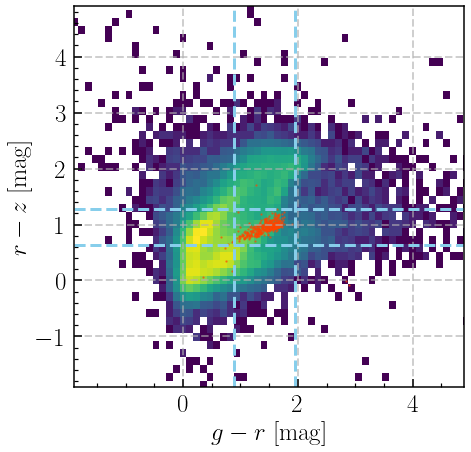

In [688]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    gr_valid_lp, rz_valid_lp, 
    bins=(150, 100), cmin=1, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    gr_lp_mass_c, rz_lp_mass_c, s=2, c='orangered', alpha=0.5
)

ax.axvline(gr_low_lp_mass_c, c='skyblue', lw=3, ls='--')
ax.axvline(gr_upp_lp_mass_c, c='skyblue', lw=3, ls='--')
ax.axhline(rz_low_lp_mass_c, c='skyblue', lw=3, ls='--')
ax.axhline(rz_upp_lp_mass_c, c='skyblue', lw=3, ls='--')

ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(-1.9, 4.9)
_ = ax.set_ylim(-1.9, 4.9)

_ = ax.set_xlabel(r'$g-r \ [\rm mag]$', fontsize=25)
_ = ax.set_ylabel(r'$r-z \ [\rm mag]$', fontsize=25)

In [678]:
c20_lp_mass_c_bluer = c20_lp_mass_c[
    (gr_lp_mass_c < gr_low_lp_mass_c) | (rz_lp_mass_c < rz_low_lp_mass_c)
]

_ = [print("{:7d}  {:8.4f}  {:8.4f}".format(obj['ID'], obj['ra'], obj['dec'])) for obj in c20_lp_mass_c_bluer]

 155225  150.4647    2.7201
 194530  149.6949    2.2207
 427483  150.4238    2.7393
 427786  149.8599    2.1488
 452223  149.8212    2.0096
 452497  149.8201    2.0093
 630005  149.4346    2.6151
 648621  150.0228    2.6674
 801514  150.3834    2.4303
 906028  149.8271    2.1893
 950981  150.1295    1.9563


In [679]:
c20_lp_mass_c_redder = c20_lp_mass_c[
    (gr_lp_mass_c > gr_upp_lp_mass_c) | (rz_lp_mass_c > rz_upp_lp_mass_c)
]

_ = [print("{:7d}  {:8.4f}  {:8.4f}".format(obj['ID'], obj['ra'], obj['dec'])) for obj in c20_lp_mass_c_redder]

 339942  149.4049    2.5785
 387931  149.9449    2.4844
 452223  149.8212    2.0096
 452497  149.8201    2.0093


In [680]:
c20_lp_mass_good = c20_lp_mass_c[
    (gr_lp_mass_c > gr_low_lp_mass_c) & (rz_lp_mass_c > rz_low_lp_mass_c) &
    (gr_lp_mass_c < gr_upp_lp_mass_c) & (rz_lp_mass_c < rz_upp_lp_mass_c)
]

#_ = [print("{:7d}  {:8.4f}  {:8.4f}".format(obj['ID'], obj['ra'], obj['dec'])) for obj in c20_lp_mass_good]

In [681]:
# Magnitude selection 

lp_g_mag_lim = (c20_valid_lp['HSC_g_MAG'] <= c20_lp_mass_good['HSC_g_MAG'].max()) 
lp_r_mag_lim = (c20_valid_lp['HSC_r_MAG'] <= c20_lp_mass_good['HSC_r_MAG'].max()) 
lp_z_mag_lim = (c20_valid_lp['HSC_z_MAG'] <= c20_lp_mass_good['HSC_z_MAG'].max()) 

print(lp_g_mag_lim.sum(), lp_r_mag_lim.sum(), lp_z_mag_lim.sum())

10866 4631 3113


In [682]:
print("# Just one color selection:")
print("g-r selection: ", ((gr_valid_lp >= gr_low_lp_mass_c) & (gr_valid_lp <= gr_upp_lp_mass_c)).sum())
print("r-z selection: ", ((rz_valid_lp >= rz_low_lp_mass_c) & (rz_valid_lp <= rz_upp_lp_mass_c)).sum())
print("g-z selection: ", ((gz_valid_lp >= gz_low_lp_mass_c) & (gz_valid_lp <= gz_upp_lp_mass_c)).sum())

print("\n# Magnitude cut & one color selection:")
print("- Using r-band magnitude:")
print("g-r selection: ", ((gr_valid_lp[lp_r_mag_lim] >= gr_low_lp_mass_c) & (gr_valid_lp[lp_r_mag_lim] <= gr_upp_lp_mass_c)).sum())
print("r-z selection: ", ((rz_valid_lp[lp_r_mag_lim] >= rz_low_lp_mass_c) & (rz_valid_lp[lp_r_mag_lim] <= rz_upp_lp_mass_c)).sum())
print("g-z selection: ", ((gz_valid_lp[lp_r_mag_lim] >= gz_low_lp_mass_c) & (gz_valid_lp[lp_r_mag_lim] <= gz_upp_lp_mass_c)).sum())
print("- Using z-band magnitude:")
print("g-r selection: ", ((gr_valid_lp[lp_z_mag_lim] >= gr_low_lp_mass_c) & (gr_valid_lp[lp_z_mag_lim] <= gr_upp_lp_mass_c)).sum())
print("r-z selection: ", ((rz_valid_lp[lp_z_mag_lim] >= rz_low_lp_mass_c) & (rz_valid_lp[lp_z_mag_lim] <= rz_upp_lp_mass_c)).sum())
print("g-z selection: ", ((gz_valid_lp[lp_z_mag_lim] >= gz_low_lp_mass_c) & (gz_valid_lp[lp_z_mag_lim] <= gz_upp_lp_mass_c)).sum())

# Just one color selection:
g-r selection:  38482
r-z selection:  74502
g-z selection:  38639

# Magnitude cut & one color selection:
- Using r-band magnitude:
g-r selection:  2373
r-z selection:  2456
g-z selection:  2176
- Using z-band magnitude:
g-r selection:  2044
r-z selection:  1972
g-z selection:  1910


/tmp/ipykernel_89889/1799484385.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


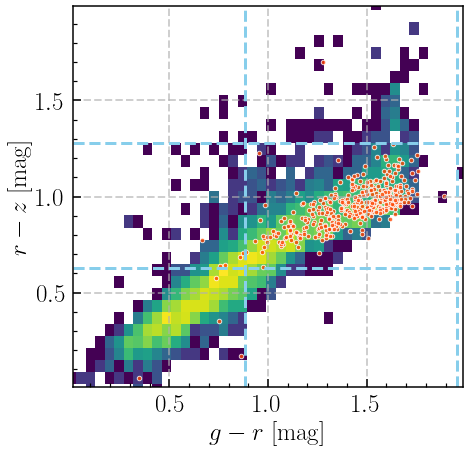

In [683]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    gr_valid_lp[lp_r_mag_lim], rz_valid_lp[lp_r_mag_lim], 
    bins=(100, 100), cmin=1, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    gr_lp_mass_c, rz_lp_mass_c,
    s=20, facecolor='orangered', edgecolor='w', alpha=0.8
)

ax.axvline(gr_low_lp_mass_c, c='skyblue', lw=3, ls='--')
ax.axvline(gr_upp_lp_mass_c, c='skyblue', lw=3, ls='--')
ax.axhline(rz_low_lp_mass_c, c='skyblue', lw=3, ls='--')
ax.axhline(rz_upp_lp_mass_c, c='skyblue', lw=3, ls='--')

ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(0.01, 1.99)
_ = ax.set_ylim(0.01, 1.99)

_ = ax.set_xlabel(r'$g-r \ [\rm mag]$', fontsize=25)
_ = ax.set_ylabel(r'$r-z \ [\rm mag]$', fontsize=25)

### Compare the LePhare and EAZY results

- Always use `LePhare - EAZY`

In [684]:
ez_mask = (c20_valid_lp['ez_mass'] > 0) & (c20_valid_lp['ez_z_phot'] > 0)

#### Stellar Mass:

- Differences for low-$z$ massive galaxies look normal
    - For $M_{\star} > 10^{10} M_{\odot}$ and $z<0.55$ ones: mean offset is -0.12 dex; scatter is 0.18 dex
    - For $M_{\star} > 10^{11} M_{\odot}$ and $z<0.55$ ones: mean offset is 0.02 dex; scatter is 0.21 dex
- For the selected massive galaxy sample:
    - Mean offset is -0.01 dex; scatter is 0.13 dex
    - **15** galaxies with absolute mass difference larger than 0.26 dex (2-$\sigma$), check their images: 
        - 4 are junks; most looks really compact or at higher redshift to be included in the real massive sample.

- There is a significant amount of outliers at $8 < \log M_{\star} < 10$ where `LePhare`'s estimates are much higher.
    - Compared to the structures on the redshift v.s. $\Delta\log M_{\star}$ plot, these are mostly $2 < z_{\rm LP} < 4$ objects.


/tmp/ipykernel_89889/2454556288.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


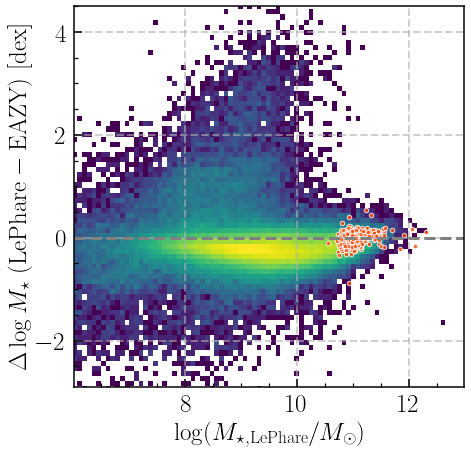

In [685]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    c20_valid_lp['lp_mass_med'][ez_mask], c20_valid_lp['lp_mass_med'][ez_mask] - c20_valid_lp['ez_mass'][ez_mask],
    bins=(100, 100), cmin=1, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    c20_lp_mass_good['lp_mass_best'], c20_lp_mass_good['lp_mass_best'] - c20_lp_mass_good['ez_mass'],
    s=20, facecolor='orangered', edgecolor='w', alpha=0.8
)

ax.axhline(0.0, linestyle='--', linewidth=3.0, c='grey')
ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(6.01, 12.99)
_ = ax.set_ylim(-2.9, 4.5)

_ = ax.set_xlabel(r'$\log (M_{\star, \rm LePhare}/M_{\odot})$', fontsize=25)
_ = ax.set_ylabel(r'$\Delta \log M_{\star}\ (\rm LePhare - EAZY)\ [\rm dex]$', fontsize=25)

In [686]:
m = ((c20_valid_lp['lp_mass_med'][ez_mask] > 11.0) & (c20_valid_lp['lp_zPDF'][ez_mask] <= 0.55))

delta_logm = (c20_valid_lp['lp_mass_med'][ez_mask] - c20_valid_lp['ez_mass'][ez_mask])[m]

print(np.nanmean(delta_logm), np.nanstd(delta_logm))

0.019988896149646104 0.20540785592187916


In [687]:
delta_logm = (c20_lp_mass_good['lp_mass_med'] - c20_lp_mass_good['ez_mass'])

print(np.nanmean(delta_logm), np.nanstd(delta_logm))

-0.010512071837631268 0.12838059709910854


In [476]:
mass_diff = c20_lp_mass_good[np.abs(delta_logm) >= (0.13 * 2.)]

print(len(mass_diff))

_ = [print("{:7d}  {:8.4f}  {:8.4f}".format(obj['ID'], obj['ra'], obj['dec'])) for obj in mass_diff]

15
  34481  150.1958    2.7943
 101949  150.4773    2.7976
 112837  150.4446    2.5477
 117072  150.4464    2.5496
 137556  149.5226    2.1347
 426430  150.3325    2.2423
 433522  150.7646    2.7588
 454176  150.2416    2.3211
 504109  150.4453    2.4245
 536524  150.3907    2.0857
 628319  150.4131    1.7619
 776764  150.5728    2.1077
 807457  150.7726    1.7052
 809376  150.4197    1.7757
 942125  149.7026    2.0330


/tmp/ipykernel_89889/186089754.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


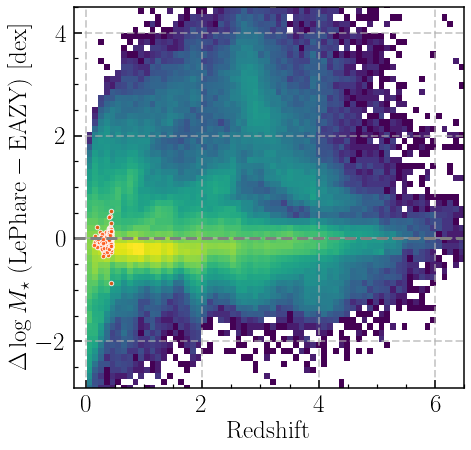

In [487]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    c20_valid_lp['lp_zPDF'][ez_mask], c20_valid_lp['lp_mass_med'][ez_mask] - c20_valid_lp['ez_mass'][ez_mask],
    bins=(100, 100), cmin=1, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    c20_lp_mass_good['lp_zPDF'], c20_lp_mass_good['lp_mass_best'] - c20_lp_mass_good['ez_mass'],
    s=20, facecolor='orangered', edgecolor='w', alpha=0.8
)

ax.axhline(0.0, linestyle='--', linewidth=3.0, c='grey')
ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(-0.2, 6.5)
_ = ax.set_ylim(-2.9, 4.5)

_ = ax.set_xlabel(r'$\rm Redshift$', fontsize=25)
_ = ax.set_ylabel(r'$\Delta \log M_{\star}\ (\rm LePhare - EAZY)\ [\rm dex]$', fontsize=25)

#### Redshift 

- Among the `LePhare` massive sample, 
    - There are two clear outliers: one look like a real low-$z$ massive galaxy, and `EAZY` over-estimates its photo-z by a lot; The other is a junk.
    - Removing these two, the rest have mean offset 0.021 and scatter of 0.040. 
        - Not terrible, but also not very good **even with the COSMOS new photo-$z$**.

/tmp/ipykernel_89889/3234851219.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


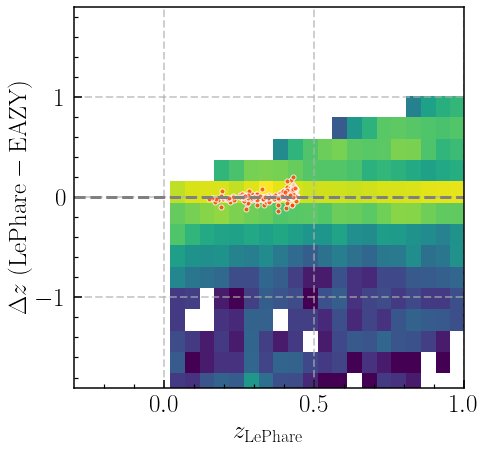

In [495]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)


# 2-D histogram
ax.hist2d(
    c20_valid_lp['lp_zPDF'][ez_mask], c20_valid_lp['lp_zPDF'][ez_mask] - c20_valid_lp['ez_z_phot'][ez_mask],
    bins=(200, 100), cmin=1, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    c20_lp_mass_good['lp_zPDF'], c20_lp_mass_good['lp_zPDF'] - c20_lp_mass_good['ez_z_phot'],
    s=25, facecolor='orangered', edgecolor='w', alpha=0.8
)

ax.axhline(0.0, linestyle='--', linewidth=3.0, c='grey')
ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(-0.3, 1.0)
_ = ax.set_ylim(-1.9, 1.9)

_ = ax.set_xlabel(r'$z_{\rm LePhare}$', fontsize=25)
_ = ax.set_ylabel(r'$\Delta z\ (\rm LePhare - EAZY)$', fontsize=25)

In [493]:
temp = c20_lp_mass_good[(c20_lp_mass_good['lp_zPDF'] - c20_lp_mass_good['ez_z_phot']) < -0.5]

_ = [print("{:7d}  {:8.4f}  {:8.4f}".format(obj['ID'], obj['ra'], obj['dec'])) for obj in temp]

 112837  150.4446    2.5477
 628319  150.4131    1.7619


In [494]:
m = (c20_lp_mass_good['lp_zPDF'] - c20_lp_mass_good['ez_z_phot']) > -0.5
diff_z = (c20_lp_mass_good['lp_zPDF'][m] - c20_lp_mass_good['ez_z_phot'][m])

print(np.nanmean(diff_z), np.nanstd(diff_z))

0.021406092861833162 0.039728035332859825


### Select massive galaxies using `EAZY`

- In the `Farmer` catalogs, the `Tractor` `SOLUTION_MODEL` is _NOT_ a very good Star-Galaxy classification criteria.
    - For `EAZY`, a lot of "galaxies" are actually stars using the HSC images and optical colors.
    - The `EAZY` star and galaxy template fitting minimum $\chi^2$ value is a useful criteria.

- Use the `EAZY` photo-z as the reference for photo-z, stellar mass, and sSFR estimates. 
    - There are **225345** objects with valid HSC five-band photometry and `LePhare` info.
	- **184586** objects have both `LePhare` and `EAZY` estimates.
	- **12436** objects have useful `LePhare` estimates; but doesn't have useful `EAZY` one.
	- **40759** objects have useful `EAZY` estimates; but doesn't have useful `LePhare` one.
    
- **Note**:
    - `EAZY` is using a slightly different cosmology model with `LePhare`: $H_0=69.4$, $\Omega_{m}=0.287$, $\Omega_{\Lambda}=0.713$.
        - This will translate into slightly different stellar mass "zeropoint", lead to number difference.
    - `EAZY` is also using the `FSPS` stellar population model with the Kriek & Conroy dust extinction model.
        - Based on Huang et al. (2018b) Appendix C, using `FSPS` model leads to higher stellar mass estimate by ~0.1 dex when compared to the `BC03` one.

In [727]:
c20_ez_flag = (
    np.isfinite(c20_hsc['ez_z_phot']) & np.isfinite(c20_hsc['ez_mass']) & 
    np.isfinite(c20_hsc['ez_sfr']) & np.isfinite(c20_hsc['ez_ssfr_p500']) &
    np.isfinite(c20_hsc['HSC_g_MAG']) & np.isfinite(c20_hsc['HSC_g_MAGERR']) &
    np.isfinite(c20_hsc['HSC_r_MAG']) & np.isfinite(c20_hsc['HSC_r_MAGERR']) &
    np.isfinite(c20_hsc['HSC_i_MAG']) & np.isfinite(c20_hsc['HSC_i_MAGERR']) &
    np.isfinite(c20_hsc['HSC_z_MAG']) & np.isfinite(c20_hsc['HSC_z_MAGERR']) &
    np.isfinite(c20_hsc['HSC_y_MAG']) & np.isfinite(c20_hsc['HSC_y_MAGERR']) &
    c20_hsc_extend_flag.data &
    (c20_hsc['ez_star_min_chi2'] - c20_hsc['ez_z_phot_chi2'] > 0)
)

c20_valid_ez = c20_hsc[c20_ez_flag]

print(len(c20_valid_ez))

225345


In [728]:
print((c20_ez_flag.data & c20_lp_flag.data).sum(), (c20_lp_flag.data & ~c20_ez_flag.data).sum(), (~c20_lp_flag.data & c20_ez_flag.data).sum())

lp_not_ez = (c20_lp_flag.data & ~c20_ez_flag.data)
ez_not_lp = (~c20_lp_flag.data & c20_ez_flag.data)

184586 12436 40759


### Safer Choice

- Using the 1-Sigma range of the photo-z PDF (`lp_zPDF_l68` & `lp_zPDF_u68`) and the 1-Sigma range of the stellar mass PDF (`lp_mass_med_min68` & `lp_mass_med_max68`) as boundaries:
	- Higher redshift cut:
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{10.5} M_{\star}$:  2736
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{10.8} M_{\star}$:  1230
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{11.0} M_{\star}$:  542
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{11.5} M_{\star}$:  81
	- Lower redshift cut:
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{10.5} M_{\star}$:  2369
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{10.8} M_{\star}$:  **1154**; Use this as the fiducial low-z massive galaxy cut.
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.0} M_{\star}$:  609
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.2} M_{\star}$:  241
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.5} M_{\star}$:  43
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.6} M_{\star}$:  24 
       
- The fiducial sample size is >2 times larger than the `LePhare` ones.
    - **We are almost certainly sure that these numbers are too high!**

In [743]:
# s means safer
c20_ez_mass_s = c20_valid_ez[
    (c20_valid_ez['ez_z160'].data >= 0.05) & (c20_valid_ez['ez_z840'].data <= 0.55) &
    (np.log10(c20_valid_ez['ez_mass_p160'].data) >= 11.0) & (np.log10(c20_valid_ez['ez_mass_p840'].data) <= 12.7)
]

print(len(c20_ez_mass_s))

542


In [730]:
ez_z_flag = (c20_valid_ez['ez_z160'] >= 0.05) & (c20_valid_ez['ez_z840'] <= 0.45)
lp_z_flag = (c20_valid_lp['lp_zPDF_l68'] >= 0.05) & (c20_valid_lp['lp_zPDF_u68'] <= 0.45)

print(ez_z_flag.sum(), lp_z_flag.sum())

ez_m_flag = (np.log10(c20_valid_ez['ez_mass_p160']) >= 10.8) & (np.log10(c20_valid_ez['ez_mass_p840']) <= 12.7)
lp_m_flag = (c20_valid_lp['lp_mass_med_min68'] >= 10.8) & (c20_valid_lp['lp_mass_med_max68'] <= 12.7)

print(ez_m_flag.sum(), lp_m_flag.sum())

37546 27861
21518 8028


### Complete Choice:

- Using the 1-Sigma range of the photo-z PDF (`ez_z160` & `ez_z840`) and the 1-Sigma range of the stellar mass PDF (`ez_mass_p160` & `ez_mass_p840`) as boundaries. 
	- But use the `_p840` limit as the lower limit and the `_p160` limit as the upper boundary:
	- Higher redshift cut:
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{10.5} M_{\star}$:  4428
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{10.8} M_{\star}$:  2270
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{11.0} M_{\star}$:  1228
		- $0.05 < z < 0.55$ and $M_{\star} > 10^{11.5} M_{\star}$:  132
	- Lower redshift cut:
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{10.5} M_{\star}$:  2990
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{10.8} M_{\star}$:  **1507**; Use this as the fiducial low-z massive galaxy cut.
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.0} M_{\star}$:  820
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.2} M_{\star}$:  347
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.5} M_{\star}$:  75
		- $0.05 < z < 0.45$ and $M_{\star} > 10^{11.6} M_{\star}$:  45
        
- Sample size varies around 20-30% due to the `EAZY` photo-z and stellar mass PDFs.

In [731]:
# c means more complete
c20_ez_mass_c = c20_valid_ez[
    (c20_valid_ez['ez_z840'] >= 0.05) & (c20_valid_ez['ez_z160'] <= 0.45) &
    (np.log10(c20_valid_ez['ez_mass_p840']) >= 10.8) & (np.log10(c20_valid_ez['ez_mass_p160']) <= 12.7)
]

print(len(c20_ez_mass_c))

print((len(c20_ez_mass_c) - len(c20_ez_mass_s)) / len(c20_ez_mass_c))

1082
0.300369685767098


### `EAZY` - Complete - Magnitued and Color Ranges 

- Using `HSC` photometry:

#### HSC magnitude: 

- $g_{\rm Max} = 23.0$ mag : 3.7% of the sample after a magnitude cut.
- $r_{\rm Max} = 21.4$ mag : 8.8% of the sample after a magnitude cut.
- $i_{\rm Max} = 20.6$ mag : 11.9% of the sample after a magnitude cut.
- $z_{\rm Max} = 20.2$ mag : 13.2% of the sample after a magnitude cut.
	- **$z$-band photometry is the most constraining one if ignoring the data quality issue.**

In [732]:
ez_g_lim = np.percentile(c20_ez_mass_s['HSC_g_MAG'], 99.9)
ez_r_lim = np.percentile(c20_ez_mass_s['HSC_r_MAG'], 99.9)
ez_i_lim = np.percentile(c20_ez_mass_s['HSC_i_MAG'], 99.9)
ez_z_lim = np.percentile(c20_ez_mass_s['HSC_z_MAG'], 99.9)

ez_g_flag = (c20_valid_ez['HSC_g_MAG'] <= ez_g_lim)
ez_r_flag = (c20_valid_ez['HSC_r_MAG'] <= ez_r_lim)
ez_i_flag = (c20_valid_ez['HSC_i_MAG'] <= ez_i_lim)
ez_z_flag = (c20_valid_ez['HSC_z_MAG'] <= ez_z_lim)

print(ez_g_lim, len(c20_ez_mass_s) / ez_g_flag.sum(), ez_g_flag.sum())
print(ez_r_lim, len(c20_ez_mass_s) / ez_r_flag.sum(), ez_r_flag.sum())
print(ez_i_lim, len(c20_ez_mass_s) / ez_i_flag.sum(), ez_i_flag.sum())
print(ez_z_lim, len(c20_ez_mass_s) / ez_z_flag.sum(), ez_z_flag.sum())

/Users/song/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


23.056757452918745 0.047920491232512505 15797
21.444076053972253 0.10096025606828488 7498
20.82478102350427 0.11089950190448286 6826
20.450190600837903 0.11736434108527131 6450


/tmp/ipykernel_89889/490013065.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


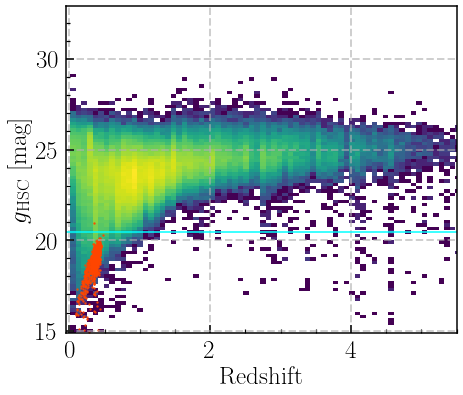

In [733]:
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    c20_valid_ez['ez_z_phot'], c20_valid_ez['HSC_z_MAG'], 
    bins=(150, 100), cmin=1, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    c20_ez_mass_s['ez_z_phot'], c20_ez_mass_s['HSC_z_MAG'], s=2, c='orangered', alpha=0.8
)

ax.axhline(ez_z_lim, c='cyan')

ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(-0.05, 5.5)
_ = ax.set_ylim(14.9, 32.9)

_ = ax.set_xlabel(r'$\rm Redshift$', fontsize=25)
_ = ax.set_ylabel(r'$g_{\rm HSC}\ [\rm mag]$', fontsize=25)

#### HSC colors: only consider $g-r$, $r-z$, and $g-z$:

- There are tiny fraction of outliers of these objects. Need to use sigma-clipping. 
	- Over the $g-r$ v.s. $r-z$ plane, the massive sample forms a triangular "wedge"-like region.
	- $(g-r)$ ranges from 0.88 - 1.96 mag
		- Along with r-band magnitude cut: **2373** objects
		- Along with z-band magnitude cut: **2044** objects
	- $(r-z)$ ranges from 0.63 - 1.28 mag
		- Along with r-band magnitude cut: **2456** objects
		- Along with z-band magnitude cut: **1972** objects
	- $(g-z)$ ranges from 1.62 - 3.26 mag
		- Along with r-band magnitude cut: **2176** objects
		- Along with z-band magnitude cut: **1910** objects
	- **$(g-z)$ color seems to be the most constraining one as a single color cut.**
	- Check the color outliers: All outliers here are junks
	- This is before taking advantage of multiple color cuts or the "wedge"-like region.

In [734]:
gr_valid_ez = c20_valid_ez['HSC_g_MAG'] - c20_valid_ez['HSC_r_MAG']
rz_valid_ez = c20_valid_ez['HSC_r_MAG'] - c20_valid_ez['HSC_z_MAG']
gz_valid_ez = c20_valid_ez['HSC_g_MAG'] - c20_valid_ez['HSC_z_MAG']

gr_ez_mass_s = c20_ez_mass_s['HSC_g_MAG'] - c20_ez_mass_s['HSC_r_MAG']
rz_ez_mass_s = c20_ez_mass_s['HSC_r_MAG'] - c20_ez_mass_s['HSC_z_MAG']
gz_ez_mass_s = c20_ez_mass_s['HSC_g_MAG'] - c20_ez_mass_s['HSC_z_MAG']

In [735]:
_, gr_low_ez_mass_s, gr_upp_ez_mass_s = sigma_clip(
    gr_ez_mass_s, sigma_lower=3, sigma_upper=2.5, maxiters=5, masked=False, return_bounds=True)
_, rz_low_ez_mass_s, rz_upp_ez_mass_s = sigma_clip(
    rz_ez_mass_s, sigma_lower=3, sigma_upper=3, maxiters=5, masked=False, return_bounds=True)
_, gz_low_ez_mass_s, gz_upp_ez_mass_s = sigma_clip(
    gz_ez_mass_s, sigma_lower=3, sigma_upper=3, maxiters=5, masked=False, return_bounds=True)

print(gr_low_ez_mass_s, gr_upp_ez_mass_s)
print(rz_low_ez_mass_s, rz_upp_ez_mass_s)
print(gz_low_ez_mass_s, gz_upp_ez_mass_s)

0.6682490688575394 1.9875281449256037
0.568942955624835 1.284902984149233
1.3202528000663483 3.3487676887881372


In [736]:
lp_mask = (
    np.isfinite(c20_ez_mass_s['lp_zBEST']) & np.isfinite(c20_ez_mass_s['lp_mass_med']) & 
    np.isfinite(c20_ez_mass_s['lp_SFR_med']) & np.isfinite(c20_ez_mass_s['lp_sSFR_med'])
)

lp_mask.sum()

477

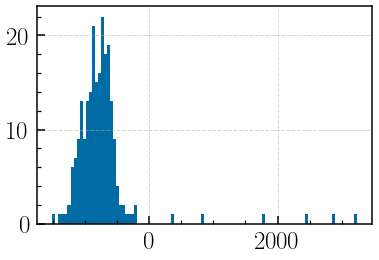

In [737]:
_ = plt.hist(ez_mass_red['ez_star_min_chi2'] - ez_mass_red['ez_z_phot_chi2'], bins=100)

In [739]:
ez_mass_red = c20_ez_mass_s[rz_ez_mass_s >= 1.25]

print(len(ez_mass_red))

_ = [print("{:7d}  {:8.4f}  {:8.4f}".format(obj['ID'], obj['ra'], obj['dec'])) for obj in ez_mass_red[(ez_mass_red['ez_star_min_chi2'] - ez_mass_red['ez_z_phot_chi2'] > 0)]]

6
 174297  150.7689    2.3860
 200905  150.6842    2.0663
 204131  149.4307    2.5749
 532339  150.0332    1.6671
 653011  150.5875    2.7580
 792846  149.2298    2.7906


/tmp/ipykernel_89889/227114298.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


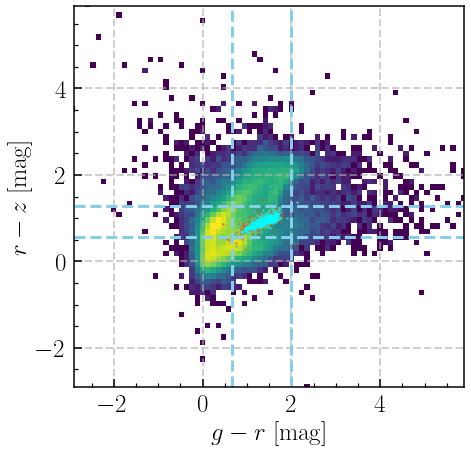

In [740]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    gr_valid_ez, rz_valid_ez, 
    bins=(150, 100), cmin=1, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    gr_ez_mass_s, rz_ez_mass_s, s=2, c='orangered', alpha=0.5
)

ax.scatter(
    gr_ez_mass_s[lp_mask], rz_ez_mass_s[lp_mask], s=2, c='cyan', alpha=0.5
)

ax.axvline(gr_low_ez_mass_s, c='skyblue', lw=3, ls='--')
ax.axvline(gr_upp_ez_mass_s, c='skyblue', lw=3, ls='--')
ax.axhline(rz_low_ez_mass_s, c='skyblue', lw=3, ls='--')
ax.axhline(rz_upp_ez_mass_s, c='skyblue', lw=3, ls='--')

ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(-2.9, 5.9)
_ = ax.set_ylim(-2.9, 5.9)

_ = ax.set_xlabel(r'$g-r \ [\rm mag]$', fontsize=25)
_ = ax.set_ylabel(r'$r-z \ [\rm mag]$', fontsize=25)

In [446]:
c20_lp_mass_c_bluer = c20_lp_mass_c[
    (gr_lp_mass_c < gr_low_lp_mass_c) | (rz_lp_mass_c < rz_low_lp_mass_c)
]

_ = [print("{:7d}  {:8.4f}  {:8.4f}".format(obj['ID'], obj['ra'], obj['dec'])) for obj in c20_lp_mass_c_bluer]

 155225  150.4647    2.7201
 194530  149.6949    2.2207
 427483  150.4238    2.7393
 427786  149.8599    2.1488
 452223  149.8212    2.0096
 452497  149.8201    2.0093
 630005  149.4346    2.6151
 648621  150.0228    2.6674
 801514  150.3834    2.4303
 906028  149.8271    2.1893
 950981  150.1295    1.9563


In [447]:
c20_lp_mass_c_redder = c20_lp_mass_c[
    (gr_lp_mass_c > gr_upp_lp_mass_c) | (rz_lp_mass_c > rz_upp_lp_mass_c)
]

_ = [print("{:7d}  {:8.4f}  {:8.4f}".format(obj['ID'], obj['ra'], obj['dec'])) for obj in c20_lp_mass_c_redder]

 339942  149.4049    2.5785
 387931  149.9449    2.4844
 452223  149.8212    2.0096
 452497  149.8201    2.0093


In [461]:
c20_lp_mass_good = c20_lp_mass_c[
    (gr_lp_mass_c > gr_low_lp_mass_c) & (rz_lp_mass_c > rz_low_lp_mass_c) &
    (gr_lp_mass_c < gr_upp_lp_mass_c) & (rz_lp_mass_c < rz_upp_lp_mass_c)
]

#_ = [print("{:7d}  {:8.4f}  {:8.4f}".format(obj['ID'], obj['ra'], obj['dec'])) for obj in c20_lp_mass_good]

In [462]:
# Magnitude selection 

lp_g_mag_lim = (c20_valid_lp['HSC_g_MAG'] <= c20_lp_mass_good['HSC_g_MAG'].max()) 
lp_r_mag_lim = (c20_valid_lp['HSC_r_MAG'] <= c20_lp_mass_good['HSC_r_MAG'].max()) 
lp_z_mag_lim = (c20_valid_lp['HSC_z_MAG'] <= c20_lp_mass_good['HSC_z_MAG'].max()) 

print(lp_g_mag_lim.sum(), lp_r_mag_lim.sum(), lp_z_mag_lim.sum())

10942 4636 3115


In [455]:
print("# Just one color selection:")
print("g-r selection: ", ((gr_valid_lp >= gr_low_lp_mass_c) & (gr_valid_lp <= gr_upp_lp_mass_c)).sum())
print("r-z selection: ", ((rz_valid_lp >= rz_low_lp_mass_c) & (rz_valid_lp <= rz_upp_lp_mass_c)).sum())
print("g-z selection: ", ((gz_valid_lp >= gz_low_lp_mass_c) & (gz_valid_lp <= gz_upp_lp_mass_c)).sum())

print("\n# Magnitude cut & one color selection:")
print("- Using r-band magnitude:")
print("g-r selection: ", ((gr_valid_lp[lp_r_mag_lim] >= gr_low_lp_mass_c) & (gr_valid_lp[lp_r_mag_lim] <= gr_upp_lp_mass_c)).sum())
print("r-z selection: ", ((rz_valid_lp[lp_r_mag_lim] >= rz_low_lp_mass_c) & (rz_valid_lp[lp_r_mag_lim] <= rz_upp_lp_mass_c)).sum())
print("g-z selection: ", ((gz_valid_lp[lp_r_mag_lim] >= gz_low_lp_mass_c) & (gz_valid_lp[lp_r_mag_lim] <= gz_upp_lp_mass_c)).sum())
print("- Using z-band magnitude:")
print("g-r selection: ", ((gr_valid_lp[lp_z_mag_lim] >= gr_low_lp_mass_c) & (gr_valid_lp[lp_z_mag_lim] <= gr_upp_lp_mass_c)).sum())
print("r-z selection: ", ((rz_valid_lp[lp_z_mag_lim] >= rz_low_lp_mass_c) & (rz_valid_lp[lp_z_mag_lim] <= rz_upp_lp_mass_c)).sum())
print("g-z selection: ", ((gz_valid_lp[lp_z_mag_lim] >= gz_low_lp_mass_c) & (gz_valid_lp[lp_z_mag_lim] <= gz_upp_lp_mass_c)).sum())

# Just one color selection:
g-r selection:  125610
r-z selection:  196371
g-z selection:  107309

# Magnitude cut & one color selection:
- Using r-band magnitude:
g-r selection:  2373
r-z selection:  2456
g-z selection:  2176
- Using z-band magnitude:
g-r selection:  2044
r-z selection:  1972
g-z selection:  1910


/tmp/ipykernel_89889/1799484385.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


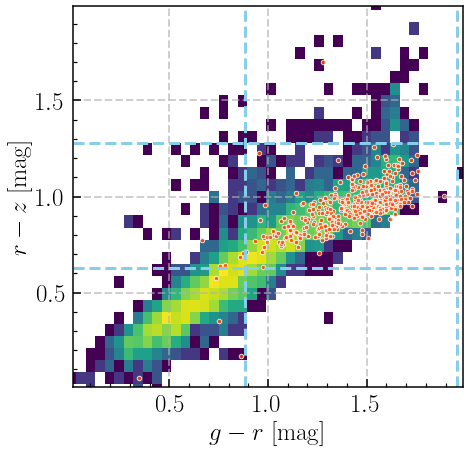

In [451]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    gr_valid_lp[lp_r_mag_lim], rz_valid_lp[lp_r_mag_lim], 
    bins=(100, 100), cmin=1, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    gr_lp_mass_c, rz_lp_mass_c,
    s=20, facecolor='orangered', edgecolor='w', alpha=0.8
)

ax.axvline(gr_low_lp_mass_c, c='skyblue', lw=3, ls='--')
ax.axvline(gr_upp_lp_mass_c, c='skyblue', lw=3, ls='--')
ax.axhline(rz_low_lp_mass_c, c='skyblue', lw=3, ls='--')
ax.axhline(rz_upp_lp_mass_c, c='skyblue', lw=3, ls='--')

ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(0.01, 1.99)
_ = ax.set_ylim(0.01, 1.99)

_ = ax.set_xlabel(r'$g-r \ [\rm mag]$', fontsize=25)
_ = ax.set_ylabel(r'$r-z \ [\rm mag]$', fontsize=25)

### Matched to the COSMOS 2020 Farmer catalog

- One-to-one best matches; ignore the unmatched cases
- Using 1.5 arcsec as matching distance
- Using `Topcat` outside the notebook
- In the COSMOS2020 `HSC` region, there are **140924** matched objects.

#### Convert the HSC magnitudes and colors into the DECam one

- Using the [ProSpect Filter Transforms](https://transformcalc.icrar.org/) service 
   - Choose to use $z=0.3$ to optimize the DECaLS massive galaxy sample. 
   - $g_{\rm DECam} = g_{\rm HSC} - 0.0156$
   - $g_{\rm DECam} = g_{\rm HSC} - 0.016 \times (g_{\rm HSC} - r_{\rm HSC}) - 0.016$
   - $r_{\rm DECam} = r_{\rm HSC} - 0.0467$
   - $r_{\rm DECam} = r_{\rm HSC} - 0.1292 \times (g_{\rm HSC} - r_{\rm HSC}) + 0.0468$
   - $z_{\rm DECam} = z_{\rm HSC} - 0.0233$
   - $z_{\rm DECam} = r_{\rm HSC} - 0.057 \times (r_{\rm HSC} - z_{\rm HSC}) + 0.0027$

In [193]:
cos_match = Table.read(
    os.path.join(decals_dir, 'decals_tractor_photoz_cosmos2020_hsc_farmer_matched_1.5arcsec.fits'))

print(len(cos_match))
print(cos_match.colnames)

140924
['ID', 'ID_CLASSIC', 'ra', 'dec', 'N_GROUP', 'FLAG_HSC', 'FLAG_UVISTA', 'FLAG_COMBINED', 'EBV_MW', 'HSC_g_MAG', 'HSC_g_MAGERR', 'HSC_g_CHISQ', 'HSC_g_VALID', 'HSC_r_MAG', 'HSC_r_MAGERR', 'HSC_r_CHISQ', 'HSC_r_VALID', 'HSC_i_MAG', 'HSC_i_MAGERR', 'HSC_i_CHISQ', 'HSC_i_VALID', 'HSC_z_MAG', 'HSC_z_MAGERR', 'HSC_z_CHISQ', 'HSC_z_VALID', 'HSC_y_MAG', 'HSC_y_MAGERR', 'HSC_y_CHISQ', 'HSC_y_VALID', 'UVISTA_Y_MAG', 'UVISTA_Y_MAGERR', 'UVISTA_Y_CHISQ', 'UVISTA_Y_VALID', 'UVISTA_J_MAG', 'UVISTA_J_MAGERR', 'UVISTA_J_CHISQ', 'UVISTA_J_VALID', 'UVISTA_H_MAG', 'UVISTA_H_MAGERR', 'UVISTA_H_CHISQ', 'UVISTA_H_VALID', 'UVISTA_Ks_MAG', 'UVISTA_Ks_MAGERR', 'UVISTA_Ks_CHISQ', 'UVISTA_Ks_VALID', 'F814W_MAG', 'F814W_MAGERR', 'lp_zBEST', 'lp_type', 'lp_zPDF', 'lp_zPDF_l68', 'lp_zPDF_u68', 'lp_MNUV', 'lp_MU', 'lp_MR', 'lp_MZ', 'lp_MJ', 'lp_mass_med', 'lp_mass_med_min68', 'lp_mass_med_max68', 'lp_mass_best', 'lp_SFR_med', 'lp_SFR_med_min68', 'lp_SFR_med_max68', 'lp_SFR_best', 'lp_sSFR_med', 'lp_sSFR_med_m

In [285]:
flag_valid = (
    (cos_match['FLUX_G'] > 0) & (cos_match['FLUX_IVAR_G'] > 0) &
    (cos_match['FLUX_R'] > 0) & (cos_match['FLUX_IVAR_R'] > 0) &
    (cos_match['FLUX_Z'] > 0) & (cos_match['FLUX_IVAR_Z'] > 0) &
    np.isfinite(cos_match['HSC_g_MAG']) & np.isfinite(cos_match['HSC_g_MAGERR']) &
    np.isfinite(cos_match['HSC_r_MAG']) & np.isfinite(cos_match['HSC_r_MAGERR']) &
    np.isfinite(cos_match['HSC_i_MAG']) & np.isfinite(cos_match['HSC_i_MAGERR']) &
    np.isfinite(cos_match['HSC_z_MAG']) & np.isfinite(cos_match['HSC_z_MAGERR']) &
    np.isfinite(cos_match['HSC_y_MAG']) & np.isfinite(cos_match['HSC_y_MAGERR'])
)

print(flag_valid.sum())

# Convert to DECam filters
r_hsc = cos_match[flag_valid]['HSC_r_MAG'] - 0.1292 * (cos_match[flag_valid]['HSC_g_MAG'] - cos_match[flag_valid]['HSC_r_MAG']) + 0.0468 
r_decals = -2.5 * np.log10(cos_match[flag_valid]['FLUX_R']) + 22.5

g_hsc = cos_match[flag_valid]['HSC_g_MAG'] - 0.016 * (cos_match[flag_valid]['HSC_g_MAG'] - cos_match[flag_valid]['HSC_r_MAG']) - 0.016
g_decals = -2.5 * np.log10(cos_match[flag_valid]['FLUX_G']) + 22.5

z_hsc = cos_match[flag_valid]['HSC_z_MAG'] - 0.057 * (cos_match[flag_valid]['HSC_r_MAG'] - cos_match[flag_valid]['HSC_z_MAG']) + 0.0027
z_decals = -2.5 * np.log10(cos_match[flag_valid]['FLUX_Z']) + 22.5

cos_valid = cos_match[flag_valid]

120811


In [299]:
lp_valid = (
    np.isfinite(cos_valid['lp_zBEST']) & np.isfinite(cos_valid['lp_mass_med']) & 
    np.isfinite(cos_valid['lp_SFR_med']) & np.isfinite(cos_valid['lp_sSFR_med'])
)

lp_valid.sum()

ez_valid = (
    np.isfinite(cos_valid['ez_z_phot']) & np.isfinite(cos_valid['ez_mass']) & 
    np.isfinite(cos_valid['ez_sfr']) & np.isfinite(cos_valid['ez_ssfr_p500'])
)

ez_valid.sum()

115485

/tmp/ipykernel_89889/1569151837.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


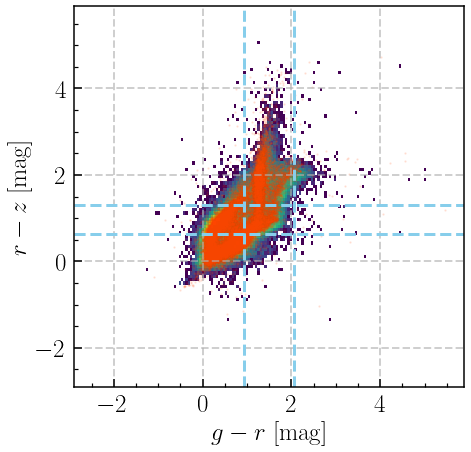

In [302]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    g_hsc - r_hsc, r_hsc - z_hsc, 
    bins=(150, 100), cmin=1, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    cos_valid[~lp_valid]['HSC_g_MAG'] - cos_valid[~lp_valid]['HSC_r_MAG'], 
    cos_valid[~lp_valid]['HSC_r_MAG'] - cos_valid[~lp_valid]['HSC_z_MAG'], 
    s=2, c='orangered', alpha=0.1
)

ax.axvline(gr_low, c='skyblue', lw=3, ls='--')
ax.axvline(gr_upp, c='skyblue', lw=3, ls='--')
ax.axhline(rz_low, c='skyblue', lw=3, ls='--')
ax.axhline(rz_upp, c='skyblue', lw=3, ls='--')

ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(-2.9, 5.9)
_ = ax.set_ylim(-2.9, 5.9)

_ = ax.set_xlabel(r'$g-r \ [\rm mag]$', fontsize=25)
_ = ax.set_ylabel(r'$r-z \ [\rm mag]$', fontsize=25)

In [265]:
massive_match = cos_match[
    (cos_match['lp_zPDF_l68'] >= 0.05) & (cos_match['lp_zPDF_l68'] <= 0.45) &
    (cos_match['lp_mass_med_min68'] >= 10.8) & (cos_match['lp_mass_med_max68'] <= 12.7) &
    flag_valid
]

print(len(massive_match))

r_hsc_massive = massive_match['HSC_r_MAG'] - 0.1292 * (massive_match['HSC_g_MAG'] - massive_match['HSC_r_MAG']) + 0.0468 
r_decals_massive = -2.5 * np.log10(massive_match['FLUX_R']) + 22.5

g_hsc_massive = massive_match['HSC_g_MAG'] - 0.0160 * (massive_match['HSC_g_MAG'] - massive_match['HSC_r_MAG']) - 0.016
g_decals_massive = -2.5 * np.log10(massive_match['FLUX_G']) + 22.5

z_hsc_massive = massive_match['HSC_z_MAG'] - 0.0570 * (massive_match['HSC_r_MAG'] - massive_match['HSC_z_MAG']) + 0.0027
z_decals_massive = -2.5 * np.log10(massive_match['FLUX_Z']) + 22.5

360


/tmp/ipykernel_89889/158008212.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


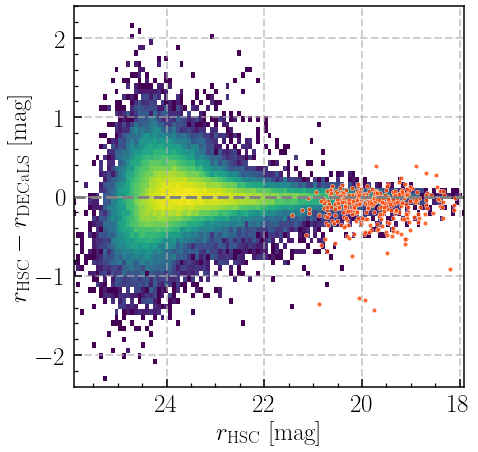

In [266]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    r_hsc, r_decals - r_hsc, 
    bins=(150, 250), cmin=2, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    r_hsc_massive, r_decals_massive - r_hsc_massive,
    s=20, facecolor='orangered', edgecolor='w', alpha=0.8, linewidth=0.5
)

ax.axhline(0.0, c='grey', lw=3, ls='--')
ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(25.9, 17.9)
_ = ax.set_ylim(-2.4, 2.4)

_ = ax.set_xlabel(r'$r_{\rm HSC} \ [\rm mag]$', fontsize=25)
_ = ax.set_ylabel(r'$r_{\rm HSC} - r_{\rm DECaLS} \ [\rm mag]$', fontsize=25)

/tmp/ipykernel_89889/837053548.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


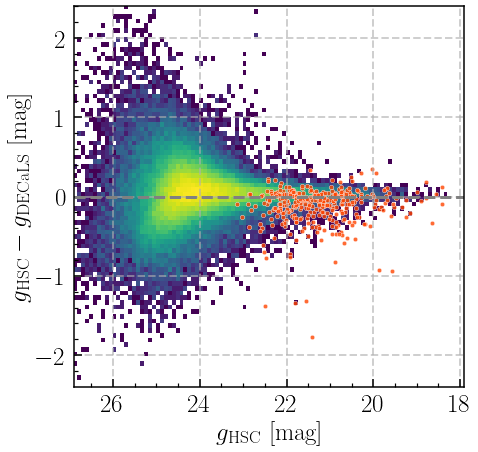

In [267]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    g_hsc, g_decals - g_hsc, 
    bins=(150, 250), cmin=2, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    g_hsc_massive, g_decals_massive - g_hsc_massive,
    s=20, facecolor='orangered', edgecolor='w', alpha=0.8, linewidth=0.5
)

ax.axhline(0.0, c='grey', lw=3, ls='--')
ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(26.9, 17.9)
_ = ax.set_ylim(-2.4, 2.4)

_ = ax.set_xlabel(r'$g_{\rm HSC} \ [\rm mag]$', fontsize=25)
_ = ax.set_ylabel(r'$g_{\rm HSC} - g_{\rm DECaLS} \ [\rm mag]$', fontsize=25)

/tmp/ipykernel_89889/3625873646.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


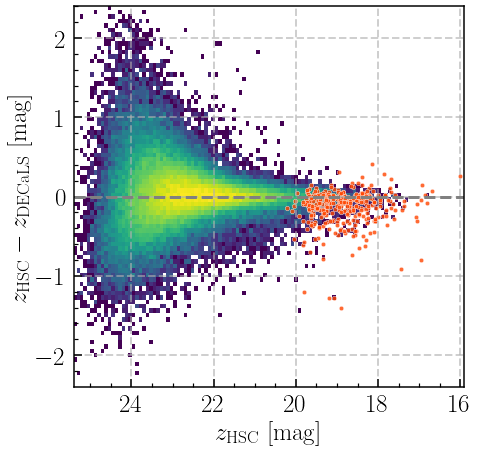

In [268]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    z_hsc, z_decals - z_hsc, 
    bins=(150, 250), cmin=2, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    z_hsc_massive, z_decals_massive - z_hsc_massive,
    s=20, facecolor='orangered', edgecolor='w', alpha=0.8, linewidth=0.5
)

ax.axhline(0.0, c='grey', lw=3, ls='--')
ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(25.4, 15.9)
_ = ax.set_ylim(-2.4, 2.4)

_ = ax.set_xlabel(r'$z_{\rm HSC} \ [\rm mag]$', fontsize=25)
_ = ax.set_ylabel(r'$z_{\rm HSC} - z_{\rm DECaLS} \ [\rm mag]$', fontsize=25)

/tmp/ipykernel_89889/4133376378.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


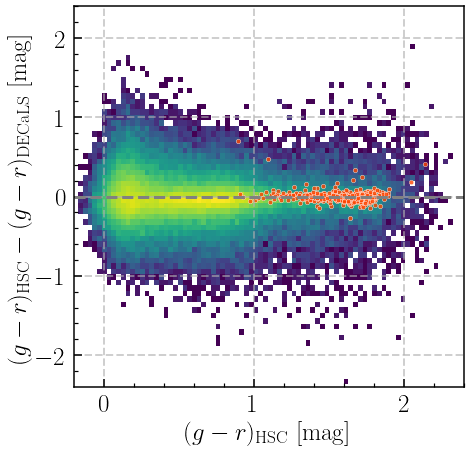

In [269]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    g_hsc - r_hsc, (g_hsc - r_hsc) - (g_decals - r_decals), 
    bins=(150, 250), cmin=3, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    g_hsc_massive - r_hsc_massive, 
    (g_hsc_massive - r_hsc_massive) - (g_decals_massive - r_decals_massive),
    s=20, facecolor='orangered', edgecolor='w', alpha=0.8, linewidth=0.5
)

ax.axhline(0.0, c='grey', lw=3, ls='--')
ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(-0.2, 2.4)
_ = ax.set_ylim(-2.4, 2.4)

_ = ax.set_xlabel(r'$(g-r)_{\rm HSC} \ [\rm mag]$', fontsize=25)
_ = ax.set_ylabel(r'$(g-r)_{\rm HSC} - (g-r)_{\rm DECaLS} \ [\rm mag]$', fontsize=25)

/tmp/ipykernel_89889/2214806065.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


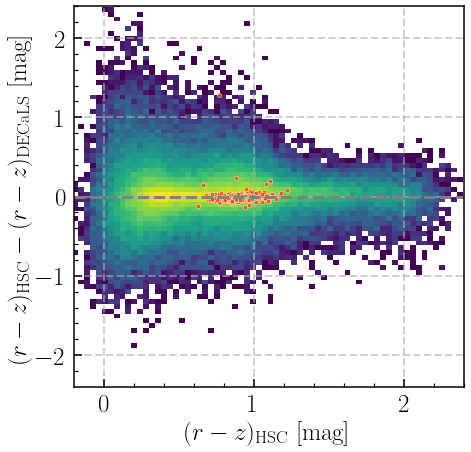

In [270]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    r_hsc - z_hsc, (r_hsc - z_hsc) - (r_decals - z_decals), 
    bins=(150, 250), cmin=3, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    r_hsc_massive - z_hsc_massive, 
    (r_hsc_massive - z_hsc_massive) - (r_decals_massive - z_decals_massive),
    s=20, facecolor='orangered', edgecolor='w', alpha=0.8, linewidth=0.5
)

ax.axhline(0.0, c='grey', lw=3, ls='--')
ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(-0.2, 2.4)
_ = ax.set_ylim(-2.4, 2.4)

_ = ax.set_xlabel(r'$(r-z)_{\rm HSC} \ [\rm mag]$', fontsize=25)
_ = ax.set_ylabel(r'$(r-z)_{\rm HSC} - (r-z)_{\rm DECaLS} \ [\rm mag]$', fontsize=25)

/tmp/ipykernel_89889/1233262855.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


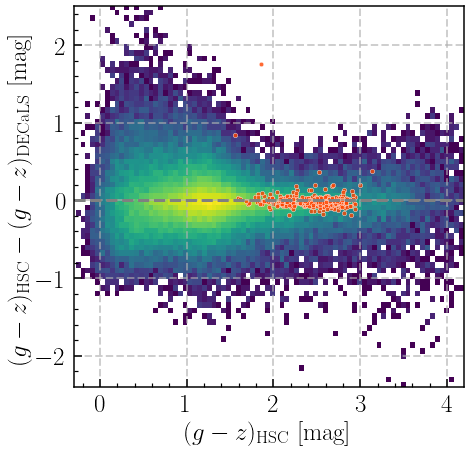

In [271]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    g_hsc - z_hsc, (g_hsc - z_hsc) - (g_decals - z_decals), 
    bins=(150, 250), cmin=3, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    g_hsc_massive - z_hsc_massive, 
    (g_hsc_massive - z_hsc_massive) - (g_decals_massive - z_decals_massive),
    s=20, facecolor='orangered', edgecolor='w', alpha=0.8, linewidth=0.5
)

ax.axhline(0.0, c='grey', lw=3, ls='--')
ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(-0.3, 4.2)
_ = ax.set_ylim(-2.4, 2.5)

_ = ax.set_xlabel(r'$(g-z)_{\rm HSC} \ [\rm mag]$', fontsize=25)
_ = ax.set_ylabel(r'$(g-z)_{\rm HSC} - (g-z)_{\rm DECaLS} \ [\rm mag]$', fontsize=25)

/tmp/ipykernel_89889/3384324521.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


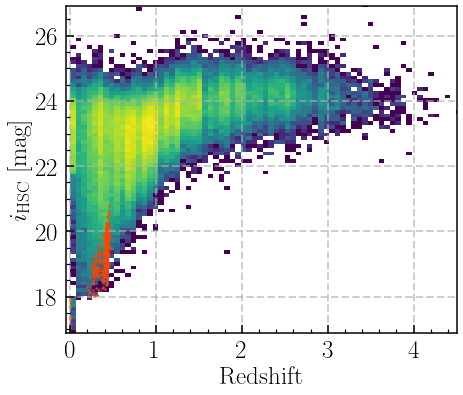

In [264]:
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    cos_match[flag_valid]['lp_zBEST'], cos_match[flag_valid]['HSC_i_MAG'], 
    bins=(100, 100), cmin=1, cmap='viridis', norm=mpl.colors.LogNorm())

ax.scatter(
    massive_match['lp_zBEST'], massive_match['HSC_i_MAG'], s=2, c='orangered', alpha=0.8
)

ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(-0.05, 4.5)
_ = ax.set_ylim(16.9, 26.9)

_ = ax.set_xlabel(r'$\rm Redshift$', fontsize=25)
_ = ax.set_ylabel(r'$i_{\rm HSC}\ [\rm mag]$', fontsize=25)

## Estimating Object Number and Density in COSMOS

### Number Counts

- Fig 11 in the paper shows the number count statistics in the 1.403/1.234 deg$^2$ region of the HSC-masked UltraVista region for the `CLASSIC` and `FARMER` catalogs.
    - For the i-band selected sample, there are $10^{4.03}$ galaxies per magnitude per square deg at $i<21.75$ AB mag; $10^{3.66}$ galaxies per magnitude per square deg at $i<20.75$ AB mag.
    
#### Compared to DESI:

- BGS Bright $r < 19.5$ mag; ~800 deg$-2$.
- BGS Faint $19.5 < r < 20$ mag; ~600 deg$-2$.
- LRG: for DECaLS, the magnitude cut is $z_{\rm fiber} < 21.5$ mag; ~600 deg$-2$.
- ELG: for DECaLS, the magnitude cut is $20 < g < 23.5$ mag; ~2400 deg$-2$

#### Compared to 4MOST

- Galaxy Clusters: $18.0 < r < 22.0$ mag; 1.7M targets
- AGN: $18.0 < r < 22.8$ mag; 1.0M targets
    - Covers 10000 deg$^2$; 
    - Density: ~90 (200) deg$^{-2}$ for X-ray wide (deep) survey; ~20 deg$^{-2}$ for IR wide survey; ~4 deg$^{-2}$ for high-z QSOs.
- WAVES: $18.0 < r < 22.5$ mag; 1.6M targets
    - In ~1200 deg$^2$ for Wide; and ~70 deg^2 for Deep
    - Wide: $Z < 21.1$ mag and $z_{\rm photo} \leq 0.2$; ~0.9M galaxies; ~750 deg$^{-2}$
    - Deep: $Z < 21.25$ mag and $z_{\rm photo} \leq 0.8$; ~0.75M galaxies; ~11000 deg$^{-2}$
        - Deep fields include GAMA23; ELAIS-S; XMMLSS; ECDFS; E-COSMOS
- Cosmology: $20.0 < r < 23.9$ mag; 8M targets: 
    - 7500 deg$^2$ for BG; LRG; QSO; ~1000 deg $^2$ for ELG
    - BG: $0.15 < z < 0.4$; $16 < J < 18$ mag or $R \sim 20.2$ mag; ~250 deg$^{-2}$; 95% complete
    - LRG: $0.4 < z < 0.7$; $18 < J < 19.5$ mag or $R \sim 21.8$ mag; ~400 deg$^{-2}$; 75% complete
    - ELG: $0.6 < z < 1.1$; $21 < g < 23.2$ mag or $R \sim 23.9$ mag; ~1200 deg$^{-2}$; 80% complete
    - QSO: $0.9 < z < 2.2$; $g < 22.5$ mag or $r \sim 22.2$ mag; ~190 deg$^{-2}$; 65% complete
    - QSO-Ly$\alpha$: $2.2 < z < 3.5$; $r < 22.7$ mag or $r \sim 22.2$ mag; ~50 deg$^{-2}$; 90% complete

#### Compared to WEAVE

- [WEAVE-QSO survey](https://www.cefca.es/doc/general_page/160/talks/WEAVE-QSO_Pieri_short.pdf): ~350K Ly$\alpha$ ($z>2$) QSO over ~6000 deg$^2$
    - **Unclear whether this is still on-going**
    - BAO measurement is better than DESI at $z>2$
    - Target selection based on J-PAS, which will be ~100% complete for $r \sim 23.2$ mag Ly$\alpha$ forrest QSOs.
    - Also work with HETDEX
    - Get all Ly$\alpha$ forrest QSOs at $r < 21$ mag.
- [WEAVE-LOFAR survey](https://arxiv.org/pdf/1611.02706.pdf)
    - Spectra of $\sim 10^6$ low-frequency selected radio sources
- WEAVE-Apertif survey:
    - LIFU follow-up of HI detected systems
- WEAVE nearby galaxy cluster survey by J.Alfonso & L.Aguerri (IAC)
    - **Note sure if there is any progress**.
    
#### Compared to PFS

- Based on Takada et al. (2014), very preliminary.

- ELGs for cosmology: $0.6 < z < 2.4$, $22.8 < g < 24.2$ AB mag; >2900 deg$^{-2}$
- Galaxy Evolution Survey: 16 deg$^2$ of HSC Deep, reaching $J = 23.4$ AB mag.
    - $J < 21$ mag for $z<1$: ~6000 deg$^{-2}$
    - $21 < J < 22$ mag for $1 < z< 2$: ~1500 deg$^{-2}$
    - $22 < J < 23$ mag for $1 < z< 2$: ~8400 deg$^{-2}$
    - $23 < J < 23.4$ mag for $1 < z< 2$: ~12000 deg$^{-2}$
    - $J < 23.4$ mag for $z<2$: ~47000 deg$^{-2}$ but only for 2.6 deg$^2$ Ultra-Deep field
    - $i = 24$ LBGs at $2 < z < 3$: ~4600 deg$^{-2}$.
    - $i = 25$ LBGs at $3 < z < 4$: ~840 deg$^{-2}$.
    - $i = 26$ LBGs at $4 < z < 6$: ~100 deg$^{-2}$.
    
#### Compared to MOONS

- [MOONRISE: GTO Extragalactic Survey](https://arxiv.org/pdf/2009.00644.pdf)
    - 1 deg$^2$ in COSMOS; 3-6 deg$^2$ in two other fields.
    - Two observing modes: Xswitch and Stare:
        - Xswitch: 400 pairs of fibers on targets or sky in nodding mode; 207800 objects in 4 deg$^2$.
        - Stare: 900 pairs of fibers on targets; 461700 objects in 7 deg$^2$.
    - $0.9 < z < 1.1$: $H <23.0$ AB mag for $\log M_{\star} > 9.5$ galaxies 
    - $1.2 < z < 1.7$: $H <23.5$ AB mag for $\log M_{\star} > 9.5$ galaxies 
    - $2.0 < z < 2.6$: $H <24.0$ AB mag for $\log M_{\star} > 10.0$ galaxies
    - $z > 5$: $H < 26$ AB mag; about 2000 galaxies

In [28]:
# Only use the objects in the HSC-masked Ultra-Vista region

c20_use = c20_short[c20_short['FLAG_COMBINED'] == 0]

print(len(c20_use))

746976


/tmp/ipykernel_89889/2206918441.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = plt.hist2d(c20_use['ra'], c20_use['dec'], bins=(100, 100))


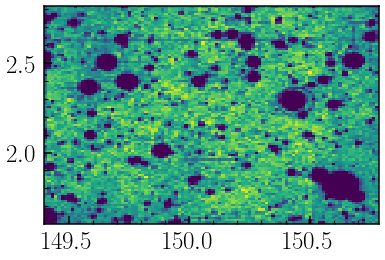

In [31]:
_ = plt.hist2d(c20_use['ra'], c20_use['dec'], bins=(100, 100))

In [32]:
c20_use.write(os.path.join(cosmos_dir, 'cosmos2020_farmer_combined_short.fits'))

In [39]:
lp_flag = (
    np.isfinite(c20_use['lp_zBEST']) & np.isfinite(c20_use['lp_mass_med']) & 
    np.isfinite(c20_use['lp_SFR_med']) & np.isfinite(c20_use['lp_sSFR_med'])
)

hsc_flag = (
    np.isfinite(c20_use['HSC_g_MAG']) & np.isfinite(c20_use['HSC_g_MAGERR']) &
    np.isfinite(c20_use['HSC_r_MAG']) & np.isfinite(c20_use['HSC_r_MAGERR']) &
    np.isfinite(c20_use['HSC_i_MAG']) & np.isfinite(c20_use['HSC_i_MAGERR']) &
    np.isfinite(c20_use['HSC_z_MAG']) & np.isfinite(c20_use['HSC_z_MAGERR']) &
    np.isfinite(c20_use['HSC_y_MAG']) & np.isfinite(c20_use['HSC_y_MAGERR'])
)

print(lp_flag.sum(), hsc_flag.sum())

712476 685165


/tmp/ipykernel_89889/3616463529.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = plt.hist2d(c20_use[lp_flag & hsc_flag]['lp_zBEST'], c20_use[lp_flag & hsc_flag]['HSC_r_MAG'], bins=(300, 100))


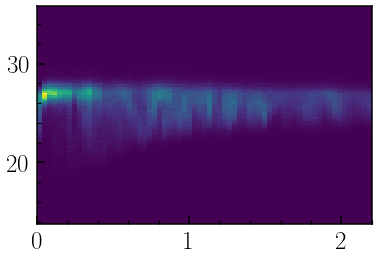

In [42]:
_ = plt.hist2d(c20_use[lp_flag & hsc_flag]['lp_zBEST'], c20_use[lp_flag & hsc_flag]['HSC_r_MAG'], bins=(300, 100))

_ = plt.xlim(0.0, 2.2)

In [45]:
np.linspace(20.0, 24.5, 10)

array([20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5])

In [47]:
np.histogram(c20_use[lp_flag & hsc_flag]['HSC_i_MAG'], bins=np.linspace(20.0, 24.5, 10))

(array([ 1365,  2231,  3782,  5830,  9103, 13378, 19554, 28360, 40170]),
 array([20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5]))